# Import Libraries

In [2]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

# Load Data

In [3]:
def load_data(path_DI, source):
    data = pd.read_csv(path_DI)
    if source:
        data = data[['Source','Polymers','Em(MPa)','Km(W/m.K)','vm','Romat', 'fl(LM)','Solids','Es(MPa)','Ks(W/m.K)','vs','Rosolid', 'fs(solid)','EffElasticMod(MPa)','EffThermCond(W/m.K)','EffDensity(g/m^3)']]
        column_map = {
            'Source':'data_source',
            'Polymers':'polymer_type',
            'Em(MPa)':'matrix_elastic_modulus',
            'Km(W/m.K)':'matrix_thermal_conductivity',
            'vm':'matrix_posson_ratio',
            'Romat':'matrix_density',
            'fl(LM)':'liquid_metal_fraction',
            'Solids':'solid_type',
            'Es(MPa)':'solid_elastic_modulus',
            'Ks(W/m.K)':'solid_thermal_conductivity',
            'vs':'solid_posson_ratio',
            'Rosolid':'solid_density',
            'fs(solid)':'solid_fraction',
            'EffElasticMod(MPa)':'composite_elastic_modulus',
            'EffThermCond(W/m.K)':'composite_thermal_conductivity',
            'EffDensity(g/m^3)':'composite_density'
        }
    else:
        data = data[['Polymers','Em(MPa)','Km(W/m.K)','vm','Romat', 'fl(LM)','Solids','Es(MPa)','Ks(W/m.K)','vs','Rosolid', 'fs(solid)','EffElasticMod(MPa)','EffThermCond(W/m.K)','EffDensity(g/m^3)']]
        column_map = {
            'Polymers':'polymer_type',
            'Em(MPa)':'matrix_elastic_modulus',
            'Km(W/m.K)':'matrix_thermal_conductivity',
            'vm':'matrix_posson_ratio',
            'Romat':'matrix_density',
            'fl(LM)':'liquid_metal_fraction',
            'Solids':'solid_type',
            'Es(MPa)':'solid_elastic_modulus',
            'Ks(W/m.K)':'solid_thermal_conductivity',
            'vs':'solid_posson_ratio',
            'Rosolid':'solid_density',
            'fs(solid)':'solid_fraction',
            'EffElasticMod(MPa)':'composite_elastic_modulus',
            'EffThermCond(W/m.K)':'composite_thermal_conductivity',
            'EffDensity(g/m^3)':'composite_density'
        }
    data.rename(columns=column_map, inplace=True)
    return data

# Split Data

In [4]:
source_ = False
path_DI = 'D:\Gitkraken\Second-HFC-ML-Sphere\Data generation and dataset\Dataset/combined dataset.csv'
df = load_data(path_DI, source=source_)

feature_cols = [
    'matrix_elastic_modulus', 
    'matrix_posson_ratio', 
    'matrix_thermal_conductivity', 
    'matrix_density',
    'solid_elastic_modulus', 
    'solid_posson_ratio', 
    'solid_thermal_conductivity', 
    'solid_density',
    'liquid_metal_fraction', 
    'solid_fraction'
]
target_cols = [
    'composite_elastic_modulus', 
    'composite_thermal_conductivity', 
    'composite_density'
]

X_raw = df[feature_cols].values  # shape (N,10)
Y_raw = df[target_cols].values   # shape (N,3)

print(f"Dataset shape: {X_raw.shape}, Targets shape: {Y_raw.shape}")

full_split_fraction = 0.8
train_df_ratio = 0.8
X_tv, X_test, Y_tv, Y_test = train_test_split(X_raw, Y_raw, test_size=1-full_split_fraction, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_tv, Y_tv, test_size=1-train_df_ratio, random_state=42)

print("Train shape:", X_train.shape, Y_train.shape)
print("Val   shape:", X_val.shape,   Y_val.shape)
print("Test  shape:", X_test.shape,  Y_test.shape)

Dataset shape: (27300, 10), Targets shape: (27300, 3)
Train shape: (17472, 10) (17472, 3)
Val   shape: (4368, 10) (4368, 3)
Test  shape: (5460, 10) (5460, 3)


# Data Standarlization

In [5]:
scaler_x = StandardScaler().fit(X_train)
scaler_y = StandardScaler().fit(Y_train)

X_train_scaled = scaler_x.transform(X_train)
X_val_scaled   = scaler_x.transform(X_val)
X_test_scaled  = scaler_x.transform(X_test)

Y_train_scaled = scaler_y.transform(Y_train)
Y_val_scaled   = scaler_y.transform(Y_val)
Y_test_scaled  = scaler_y.transform(Y_test)

X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
Y_train_t = torch.tensor(Y_train_scaled, dtype=torch.float32)
X_val_t   = torch.tensor(X_val_scaled,   dtype=torch.float32)
Y_val_t   = torch.tensor(Y_val_scaled,   dtype=torch.float32)
X_test_t  = torch.tensor(X_test_scaled,  dtype=torch.float32)
Y_test_t  = torch.tensor(Y_test_scaled,  dtype=torch.float32)

train_ds = TensorDataset(X_train_t, Y_train_t)
val_ds   = TensorDataset(X_val_t,   Y_val_t)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False)

# Forward net define + training

In [6]:
class ForwardNet(nn.Module):
    def __init__(self, input_dim=10, output_dim=3):
        super(ForwardNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )
    
    def forward(self, x):
        return self.net(x)

forward_net = ForwardNet(input_dim=10, output_dim=3)
optimizer_fwd = optim.Adam(forward_net.parameters(), lr=1e-3)
criterion_fwd = nn.MSELoss()

In [15]:
train_losses = []
val_losses = []

epochs_fwd = 100
for epoch in range(epochs_fwd):
    forward_net.train()
    total_loss = 0
    for x_batch, y_batch in train_loader:
        optimizer_fwd.zero_grad()
        y_pred = forward_net(x_batch)
        loss = criterion_fwd(y_pred, y_batch)
        loss.backward()
        optimizer_fwd.step()
        total_loss += loss.item()
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)  
    
    forward_net.eval()
    val_loss = 0
    with torch.no_grad():
        for x_val_b, y_val_b in val_loader:
            y_val_pred = forward_net(x_val_b)
            val_loss += criterion_fwd(y_val_pred, y_val_b).item()
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)  
    
    if (epoch+1) % 5 == 0:
        print(f"[ForwardNet] Epoch {epoch+1}/{epochs_fwd}, Train MSE={avg_train_loss:.4f}, Val MSE={avg_val_loss:.4f}")

[ForwardNet] Epoch 5/100, Train MSE=0.0008, Val MSE=0.0008
[ForwardNet] Epoch 10/100, Train MSE=0.0007, Val MSE=0.0010
[ForwardNet] Epoch 15/100, Train MSE=0.0007, Val MSE=0.0006
[ForwardNet] Epoch 20/100, Train MSE=0.0007, Val MSE=0.0006
[ForwardNet] Epoch 25/100, Train MSE=0.0006, Val MSE=0.0005
[ForwardNet] Epoch 30/100, Train MSE=0.0006, Val MSE=0.0005
[ForwardNet] Epoch 35/100, Train MSE=0.0006, Val MSE=0.0006
[ForwardNet] Epoch 40/100, Train MSE=0.0006, Val MSE=0.0012
[ForwardNet] Epoch 45/100, Train MSE=0.0005, Val MSE=0.0005
[ForwardNet] Epoch 50/100, Train MSE=0.0005, Val MSE=0.0006
[ForwardNet] Epoch 55/100, Train MSE=0.0006, Val MSE=0.0005
[ForwardNet] Epoch 60/100, Train MSE=0.0004, Val MSE=0.0003
[ForwardNet] Epoch 65/100, Train MSE=0.0004, Val MSE=0.0004
[ForwardNet] Epoch 70/100, Train MSE=0.0004, Val MSE=0.0004
[ForwardNet] Epoch 75/100, Train MSE=0.0004, Val MSE=0.0005
[ForwardNet] Epoch 80/100, Train MSE=0.0003, Val MSE=0.0004
[ForwardNet] Epoch 85/100, Train MSE=0.00

# Forward Net Visulization

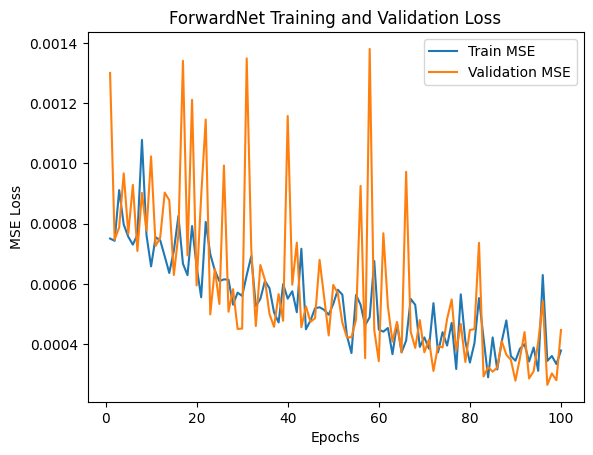

In [16]:
import matplotlib.pyplot as plt
plt.plot(range(1, epochs_fwd+1), train_losses, label='Train MSE')
plt.plot(range(1, epochs_fwd+1), val_losses, label='Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('ForwardNet Training and Validation Loss')
plt.legend()
plt.show()

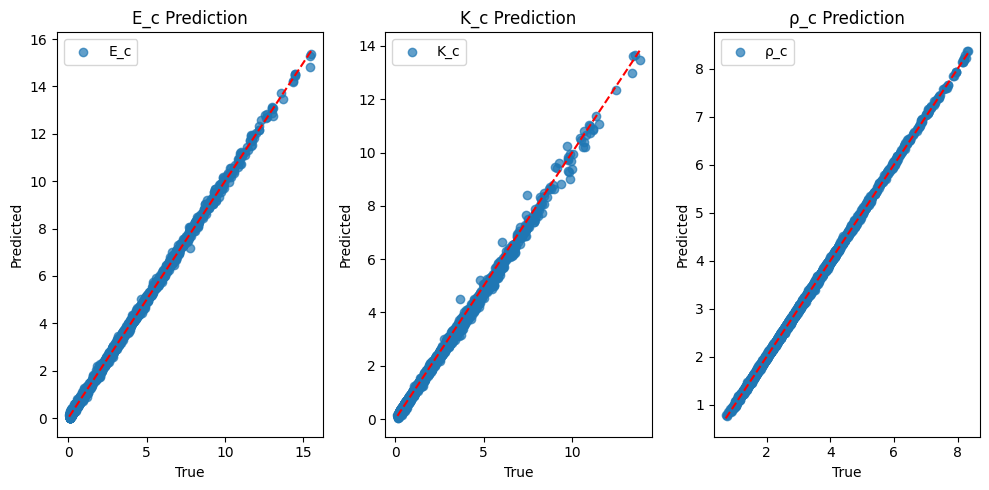

In [11]:
forward_net.eval()
with torch.no_grad():
    y_test_pred_scaled = forward_net(X_test_t).numpy()
    y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)
    y_test_true = scaler_y.inverse_transform(Y_test_t.numpy())

plt.figure(figsize=(10, 5))
for i, target_name in enumerate(['E_c', 'K_c', 'ρ_c']):
    plt.subplot(1, 3, i+1)
    plt.scatter(y_test_true[:, i], y_test_pred[:, i], alpha=0.7, label=target_name)
    plt.plot([y_test_true[:, i].min(), y_test_true[:, i].max()], 
             [y_test_true[:, i].min(), y_test_true[:, i].max()], 'r--')
    plt.xlabel('True')
    plt.ylabel('Predicted')
    plt.title(f'{target_name} Prediction')
    plt.legend()
plt.tight_layout()
plt.show()


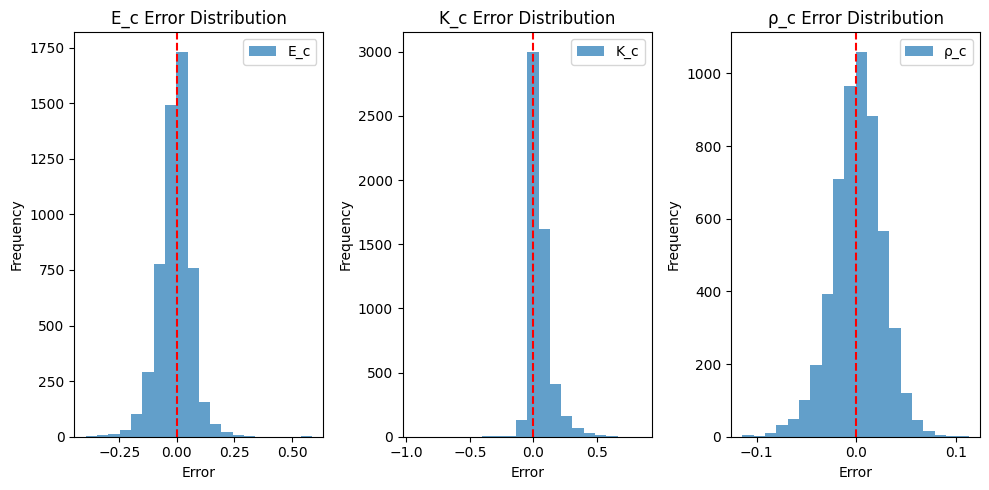

In [12]:
errors = y_test_true - y_test_pred

plt.figure(figsize=(10, 5))
for i, target_name in enumerate(['E_c', 'K_c', 'ρ_c']):
    plt.subplot(1, 3, i+1)
    plt.hist(errors[:, i], bins=20, alpha=0.7, label=target_name)
    plt.axvline(0, color='red', linestyle='--')
    plt.xlabel('Error')
    plt.ylabel('Frequency')
    plt.title(f'{target_name} Error Distribution')
    plt.legend()
plt.tight_layout()
plt.show()


# cVAE model (Encoder for (x,y) to z, Decoder for (z,y) to x)

In [61]:
class ConditionalVAE(nn.Module):
    def __init__(self, x_dim=10, y_dim=3, latent_dim=5):
        super(ConditionalVAE, self).__init__()
        self.x_dim = x_dim
        self.y_dim = y_dim
        self.latent_dim = latent_dim
        
        # Encoder: x_dim + y_dim
        self.encoder = nn.Sequential(
            nn.Linear(x_dim + y_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(32, latent_dim)
        self.fc_logvar = nn.Linear(32, latent_dim)
        
        # Decoder: latent_dim + y_dim
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + y_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, x_dim)
        )
    
    def encode(self, x, y):
        xy = torch.cat([x, y], dim=1) 
        h = self.encoder(xy)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z, y):
        zy = torch.cat([z, y], dim=1)
        return self.decoder(zy)
    
    def forward(self, x, y):
        mu, logvar = self.encode(x, y)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z, y)
        return x_recon, mu, logvar

# Define Loss function

In [62]:
def cvae_loss_function(x, x_recon, mu, logvar):
    recon_loss = nn.MSELoss(reduction='sum')(x_recon, x)
    beta=0.1
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())*beta
    return recon_loss + kl_loss

# VAE model training

In [63]:
cvae = ConditionalVAE(x_dim=len(feature_cols), y_dim=len(target_cols), latent_dim=5)
optimizer_cvae = optim.Adam(cvae.parameters(), lr=1e-3)

epochs_cvae = 100
for epoch in range(epochs_cvae):
    cvae.train()
    total_loss_c = 0
    for x_batch, y_batch in train_loader:
        optimizer_cvae.zero_grad()
        x_recon, mu, logvar = cvae(x_batch, y_batch)
        loss_c = cvae_loss_function(x_batch, x_recon, mu, logvar)
        loss_c.backward()
        optimizer_cvae.step()
        total_loss_c += loss_c.item()
    avg_loss_c = total_loss_c / len(train_loader)
    
    if (epoch+1) % 5 == 0:
        print(f"[cVAE] Epoch {epoch+1}/{epochs_cvae}, Loss={avg_loss_c:.2f}")

[cVAE] Epoch 5/100, Loss=38.31
[cVAE] Epoch 10/100, Loss=34.55
[cVAE] Epoch 15/100, Loss=32.59
[cVAE] Epoch 20/100, Loss=31.39
[cVAE] Epoch 25/100, Loss=30.47
[cVAE] Epoch 30/100, Loss=29.80
[cVAE] Epoch 35/100, Loss=29.12
[cVAE] Epoch 40/100, Loss=28.33
[cVAE] Epoch 45/100, Loss=27.96
[cVAE] Epoch 50/100, Loss=27.41
[cVAE] Epoch 55/100, Loss=26.95
[cVAE] Epoch 60/100, Loss=26.69
[cVAE] Epoch 65/100, Loss=26.57
[cVAE] Epoch 70/100, Loss=26.42
[cVAE] Epoch 75/100, Loss=26.05
[cVAE] Epoch 80/100, Loss=25.82
[cVAE] Epoch 85/100, Loss=25.81
[cVAE] Epoch 90/100, Loss=25.55
[cVAE] Epoch 95/100, Loss=25.49
[cVAE] Epoch 100/100, Loss=25.27


# VAE model visulization

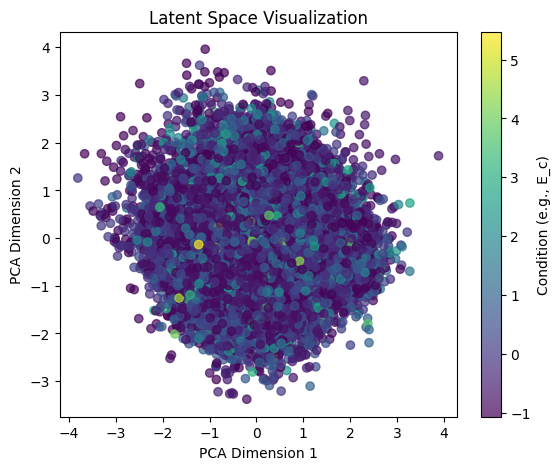

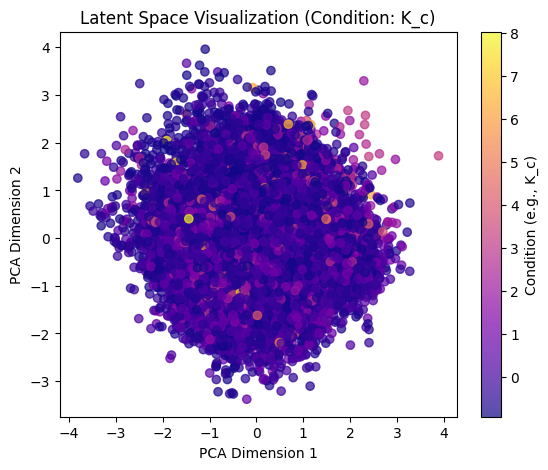

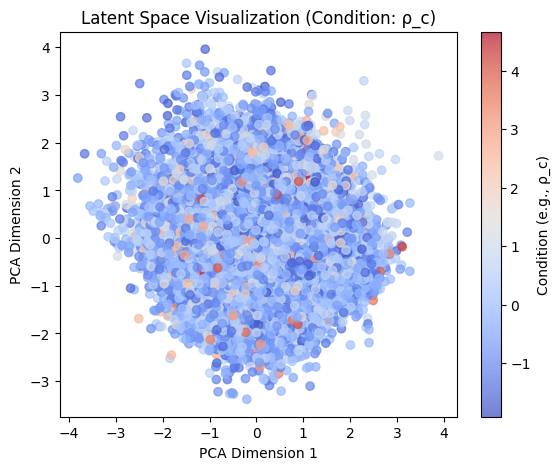

In [67]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

z_samples = []  
y_labels = []   
for x_batch, y_batch in train_loader:
    mu, logvar = cvae.encode(x_batch, y_batch)
    z = cvae.reparameterize(mu, logvar)
    z_samples.append(z.detach().numpy())
    y_labels.append(y_batch.numpy())

z_samples = np.concatenate(z_samples, axis=0)  
y_labels = np.concatenate(y_labels, axis=0)   

# PCA
pca = PCA(n_components=2)
z_2d = pca.fit_transform(z_samples)

plt.figure(figsize=(6.4, 5))
plt.scatter(z_2d[:, 0], z_2d[:, 1], c=y_labels[:, 0], cmap='viridis', alpha=0.7)  
plt.colorbar(label='Condition (e.g., E_c)')
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')
plt.title('Latent Space Visualization')
plt.show()

plt.figure(figsize=(6.4, 5))
plt.scatter(z_2d[:, 0], z_2d[:, 1], c=y_labels[:, 1], cmap='plasma', alpha=0.7)  
plt.colorbar(label='Condition (e.g., K_c)')
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')
plt.title('Latent Space Visualization (Condition: K_c)')
plt.show()

plt.figure(figsize=(6.4, 5))
plt.scatter(z_2d[:, 0], z_2d[:, 1], c=y_labels[:, 2], cmap='coolwarm', alpha=0.7) 
plt.colorbar(label='Condition (e.g., ρ_c)')
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')
plt.title('Latent Space Visualization (Condition: ρ_c)')
plt.show()



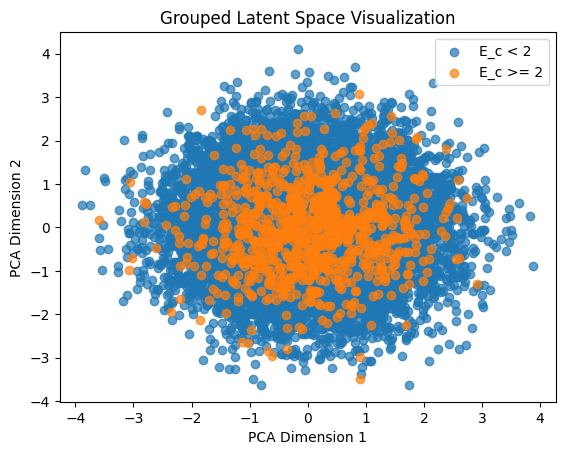

In [57]:
# Group analysis
threshold = 2
group_1 = z_2d[y_labels[:, 0] < threshold]
group_2 = z_2d[y_labels[:, 0] >= threshold]

plt.scatter(group_1[:, 0], group_1[:, 1], label=f'E_c < {threshold}', alpha=0.7)
plt.scatter(group_2[:, 0], group_2[:, 1], label=f'E_c >= {threshold}', alpha=0.7)
plt.legend()
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')
plt.title('Grouped Latent Space Visualization')
plt.show()


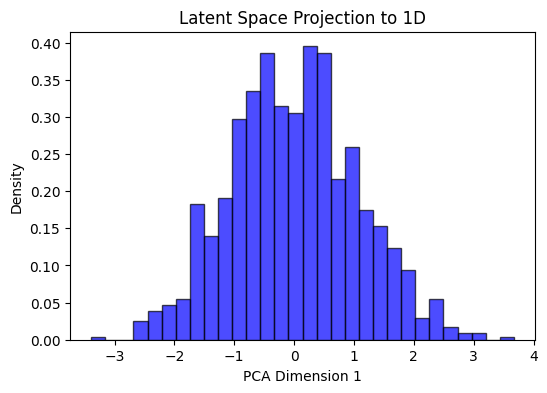

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

z_samples = np.random.normal(0, 1, size=(1000, 5)) 

pca = PCA(n_components=1)
z_1d = pca.fit_transform(z_samples).flatten()  

plt.figure(figsize=(6, 4))
plt.hist(z_1d, bins=30, density=True, alpha=0.7, color='blue', edgecolor='black')
plt.title('Latent Space Projection to 1D')
plt.xlabel('PCA Dimension 1')
plt.ylabel('Density')
plt.show()


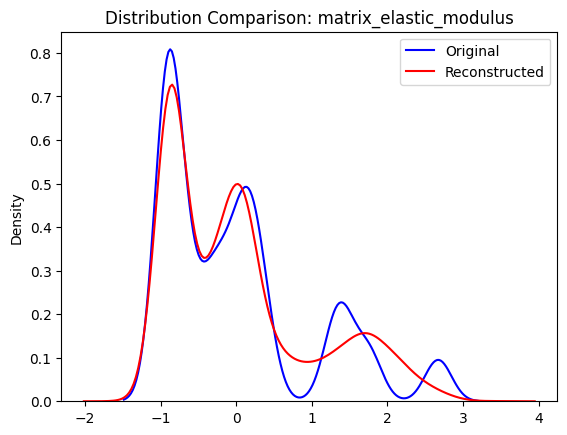

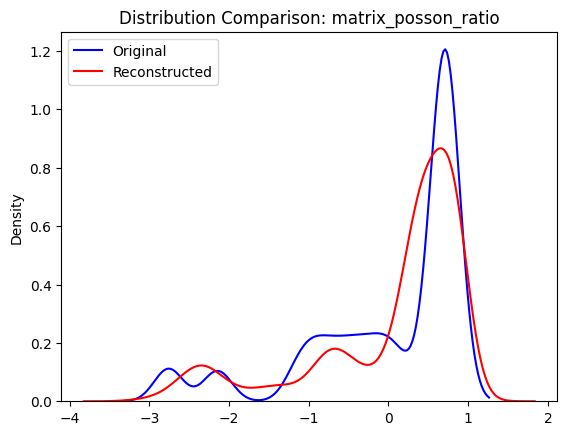

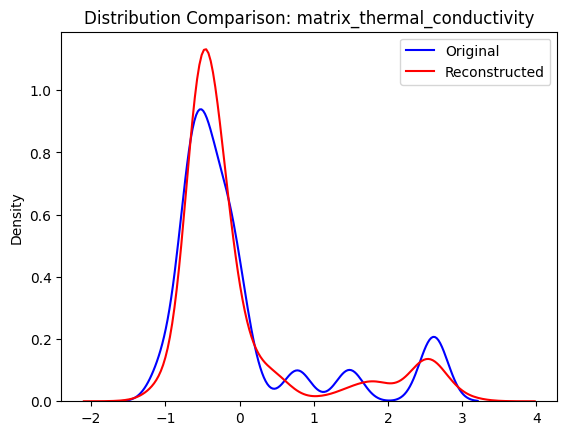

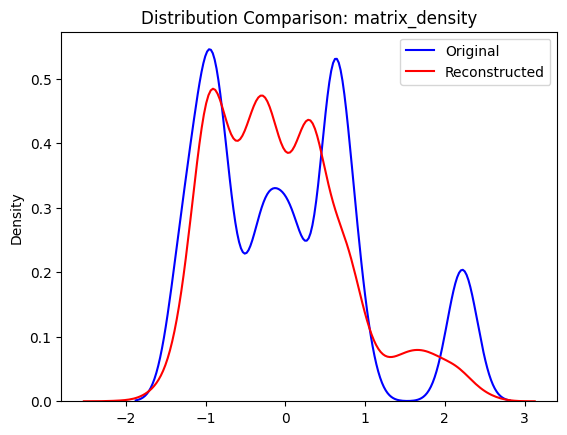

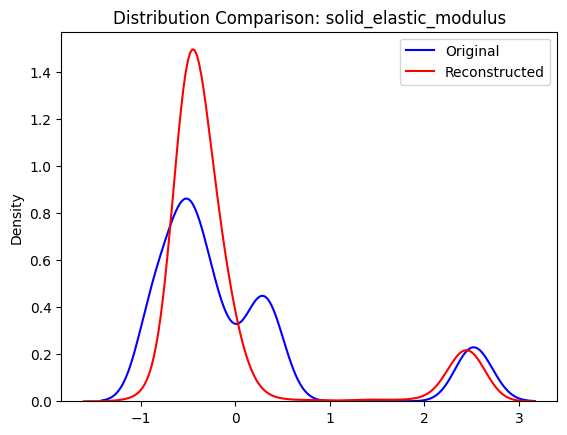

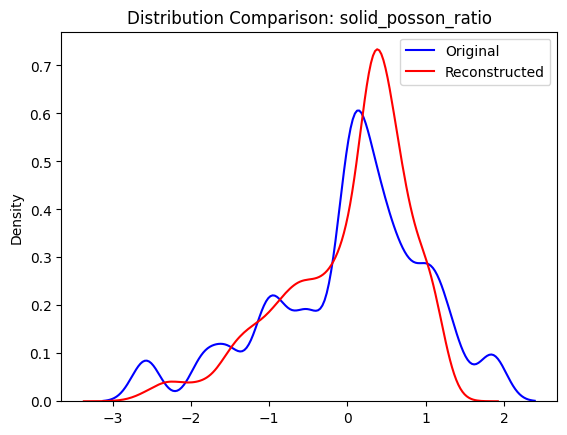

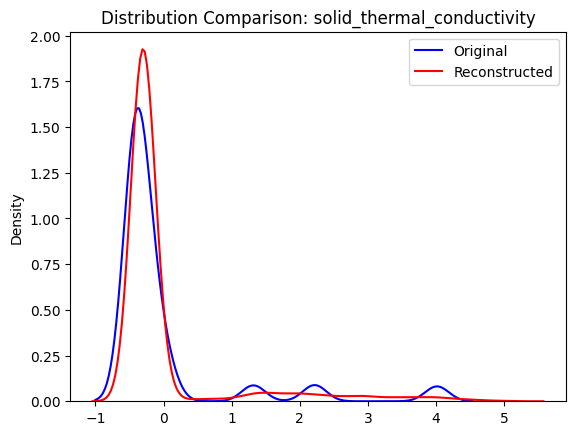

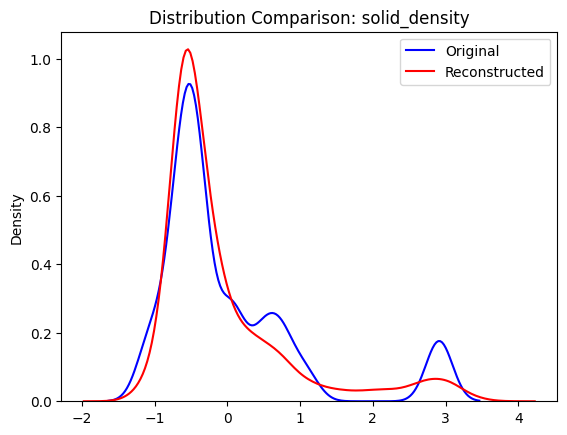

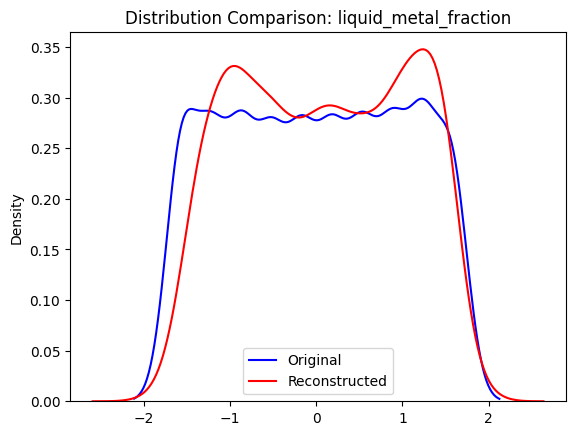

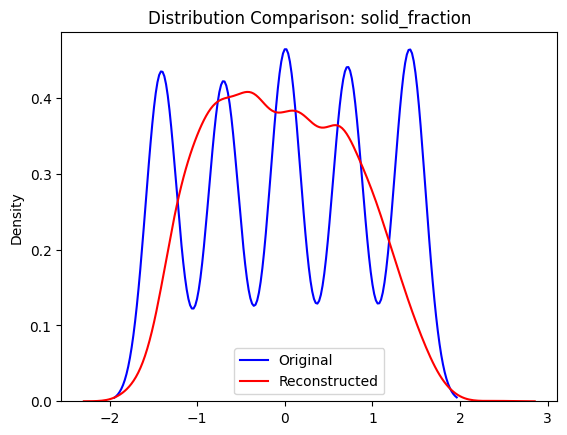

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

x = X_test_scaled  
y = Y_test_scaled  

cvae.eval()  
with torch.no_grad():
    x_torch = torch.tensor(x, dtype=torch.float32)  
    y_torch = torch.tensor(y, dtype=torch.float32)  
    x_recon_torch, _, _ = cvae(x_torch, y_torch)    
    x_recon = x_recon_torch.numpy()               

assert len(feature_cols) == x.shape[1] == x_recon.shape[1], "Feature dimensions mismatch!"


for i, feature in enumerate(feature_cols):
    plt.figure()
    sns.kdeplot(x[:, i], label='Original', color='blue')     
    sns.kdeplot(x_recon[:, i], label='Reconstructed', color='red')  
    plt.title(f'Distribution Comparison: {feature}')
    plt.legend()
    plt.show()


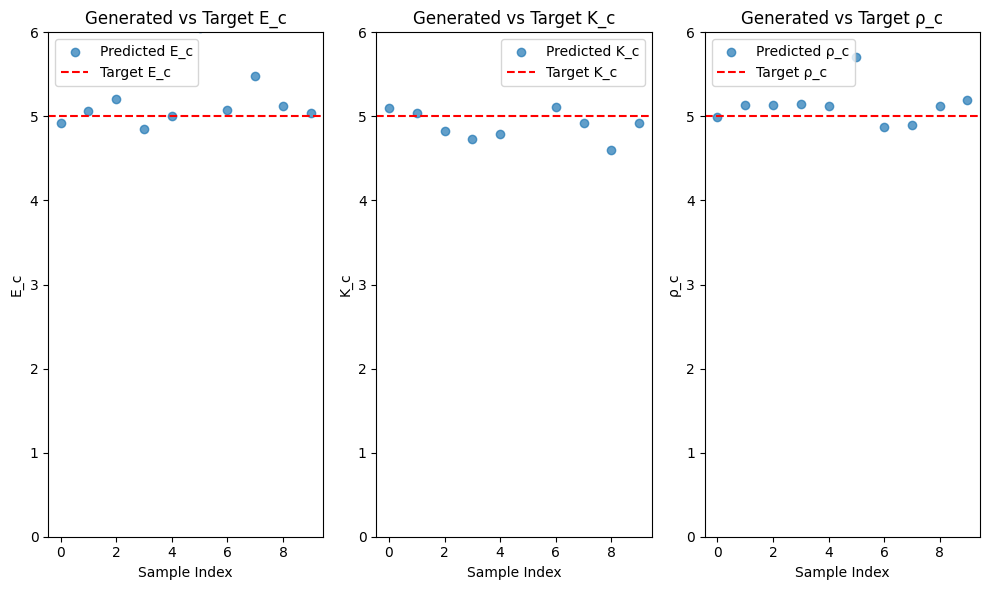

Sample 1:
  Predicted E_c=4.9238, K_c=5.0946, ρ_c=4.9976
  Target     E_c=5.0000, K_c=5.0000, ρ_c=5.0000
Sample 2:
  Predicted E_c=5.0649, K_c=5.0436, ρ_c=5.1311
  Target     E_c=5.0000, K_c=5.0000, ρ_c=5.0000
Sample 3:
  Predicted E_c=5.2022, K_c=4.8252, ρ_c=5.1410
  Target     E_c=5.0000, K_c=5.0000, ρ_c=5.0000
Sample 4:
  Predicted E_c=4.8527, K_c=4.7276, ρ_c=5.1465
  Target     E_c=5.0000, K_c=5.0000, ρ_c=5.0000
Sample 5:
  Predicted E_c=5.0016, K_c=4.7963, ρ_c=5.1249
  Target     E_c=5.0000, K_c=5.0000, ρ_c=5.0000
Sample 6:
  Predicted E_c=6.0556, K_c=6.4118, ρ_c=5.7094
  Target     E_c=5.0000, K_c=5.0000, ρ_c=5.0000
Sample 7:
  Predicted E_c=5.0796, K_c=5.1137, ρ_c=4.8728
  Target     E_c=5.0000, K_c=5.0000, ρ_c=5.0000
Sample 8:
  Predicted E_c=5.4822, K_c=4.9264, ρ_c=4.8943
  Target     E_c=5.0000, K_c=5.0000, ρ_c=5.0000
Sample 9:
  Predicted E_c=5.1196, K_c=4.6057, ρ_c=5.1229
  Target     E_c=5.0000, K_c=5.0000, ρ_c=5.0000
Sample 10:
  Predicted E_c=5.0363, K_c=4.9255, ρ_c=5.18

In [60]:
cvae.eval()
forward_net.eval()

if 'scaler_y' not in locals():
    scaler_y = StandardScaler().fit(Y_train)

y_target = np.array([[5, 5, 5]])  
y_target_scaled = scaler_y.transform(y_target)  

latent_dim = 5 
z_random = torch.randn((10, latent_dim))  

y_target_torch = torch.tensor(y_target_scaled, dtype=torch.float32)
y_repeated = y_target_torch.repeat(z_random.size(0), 1)  
x_generated = cvae.decode(z_random, y_repeated)

y_pred_scaled = forward_net(x_generated).detach().numpy()
y_pred_unscaled = scaler_y.inverse_transform(y_pred_scaled)

plt.figure(figsize=(10, 6))
target_names = ['E_c', 'K_c', 'ρ_c']  

for i, target_name in enumerate(target_names):
    plt.subplot(1, 3, i + 1) 
    plt.scatter(range(len(y_pred_unscaled)), y_pred_unscaled[:, i], label=f'Predicted {target_name}', alpha=0.7)
    plt.axhline(y=y_target[0, i], color='red', linestyle='--', label=f'Target {target_name}')  
    plt.xlabel('Sample Index')
    plt.ylabel(target_name)
    plt.ylim(0,6)
    plt.legend()
    plt.title(f'Generated vs Target {target_name}')

plt.tight_layout() 
plt.show()

for i, pred in enumerate(y_pred_unscaled):
    print(f"Sample {i+1}:")
    print(f"  Predicted E_c={pred[0]:.4f}, K_c={pred[1]:.4f}, ρ_c={pred[2]:.4f}")
    print(f"  Target     E_c={y_target[0, 0]:.4f}, K_c={y_target[0, 1]:.4f}, ρ_c={y_target[0, 2]:.4f}")

# Inverse Design without resctriction

In [11]:
cvae.eval()
forward_net.eval()

target_elastic_modulus = 3.0
target_thermal_conductivity = 5.0
target_density = 5.0

desired_target_raw = np.array([[target_elastic_modulus,
                                target_thermal_conductivity,
                                target_density]], dtype=np.float32)
desired_target_scaled = scaler_y.transform(desired_target_raw)
desired_target_torch = torch.tensor(desired_target_scaled, dtype=torch.float32)

n_samples = 1 
candidate_features_list = []
candidate_pred_targets_list = []

with torch.no_grad():
    for i in range(n_samples):
        z_rand = torch.randn((1, cvae.latent_dim))
        x_gen_scaled = cvae.decode(z_rand, desired_target_torch)
        y_pred_scaled = forward_net(x_gen_scaled)
        x_gen_unscaled = scaler_x.inverse_transform(x_gen_scaled.numpy())
        y_pred_unscaled = scaler_y.inverse_transform(y_pred_scaled.numpy())
        
        candidate_features_list.append(x_gen_unscaled)
        candidate_pred_targets_list.append(y_pred_unscaled)

for i in range(n_samples):
    x_cand = candidate_features_list[i].flatten()      # (1,10)->(10,)
    y_cand_pred = candidate_pred_targets_list[i].flatten()  # (1,3)->(3,)
    print(f"Sample {i+1} / {n_samples}")
    for j, col_name in enumerate(feature_cols):
        print(f"    {col_name}: {x_cand[j]:.4f}")  
    print(f"  Predicted Target (Unscaled):\n    {y_cand_pred}")
    print(f"  Desired Target:\n    {desired_target_raw[0]}")

Sample 1 / 1
    matrix_elastic_modulus: 2.8014
    matrix_posson_ratio: 0.4848
    matrix_thermal_conductivity: 0.2685
    matrix_density: 1.1010
    solid_elastic_modulus: 169585.2344
    solid_posson_ratio: 0.2827
    solid_thermal_conductivity: 117.9410
    solid_density: 6.8284
    liquid_metal_fraction: 0.5449
    solid_fraction: 0.1631
  Predicted Target (Unscaled):
    [2.998376 4.660968 4.786552]
  Desired Target:
    [3. 5. 5.]


# With no restriction gradient descent

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

cvae.eval()
forward_net.eval()

target_elastic_modulus = 3.0
target_thermal_conductivity = 5.0
target_density = 5.0

desired_target_raw = np.array([[target_elastic_modulus,
                                target_thermal_conductivity,
                                target_density]], dtype=np.float32)
desired_target_scaled = scaler_y.transform(desired_target_raw)        # shape (1,3)
desired_target_torch = torch.tensor(desired_target_scaled, dtype=torch.float32)

z_opt = torch.randn((1, cvae.latent_dim), requires_grad=True)  
z_optimizer = optim.Adam([z_opt], lr=1e-2)                     
criterion_mse = nn.MSELoss()

n_steps = 200  

for step in range(n_steps):
    z_optimizer.zero_grad()
    x_gen_scaled = cvae.decode(z_opt, desired_target_torch)
    y_pred_scaled = forward_net(x_gen_scaled)
    loss_z = criterion_mse(y_pred_scaled, desired_target_torch)
    loss_z.backward()
    z_optimizer.step()
    if (step + 1) % 50 == 0:
        print(f"Step {step+1}, Loss={loss_z.item():.6f}")
x_gen_scaled_final = cvae.decode(z_opt, desired_target_torch)
y_pred_scaled_final = forward_net(x_gen_scaled_final)

x_gen_unscaled = scaler_x.inverse_transform(x_gen_scaled_final.detach().numpy())
y_pred_unscaled = scaler_y.inverse_transform(y_pred_scaled_final.detach().numpy())

for j, col_name in enumerate(feature_cols):
    print(f"  {col_name}: {x_gen_unscaled[0, j]:.4f}")
print("\n  Predicted Target (Unscaled):", y_pred_unscaled[0])
print("  Desired Target            :", desired_target_raw[0])


Step 50, Loss=0.001223
Step 100, Loss=0.001135
Step 150, Loss=0.000241
Step 200, Loss=0.000021
  matrix_elastic_modulus: 1.5841
  matrix_posson_ratio: 0.4802
  matrix_thermal_conductivity: 0.3210
  matrix_density: 0.8761
  solid_elastic_modulus: 59825.6289
  solid_posson_ratio: 0.3351
  solid_thermal_conductivity: 183.7224
  solid_density: 8.2857
  liquid_metal_fraction: 0.4489
  solid_fraction: 0.2370

  Predicted Target (Unscaled): [2.9821455 4.997475  4.9998116]
  Desired Target            : [3. 5. 5.]


# Inverse design with restriction?